# Mouse Based User Identification 
Below is an analysis of dataset: https://huggingface.co/datasets/dejanseo/mouse_movement_tracking. 

The goal is to extract useful features from this mouse movement data - behavioral signals that could be unique to a user

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from datasets import load_dataset

cursor_data = load_dataset("dejanseo/mouse_movement_tracking")

In [2]:
#Logging into huggingface: honestly not sure if needed (documentation says necessary)
from huggingface_hub import notebook_login 
notebook_login() 

In [3]:
print(cursor_data)
#observations:685,529 raw mouse movement records in the train split 

DatasetDict({
    train: Dataset({
        features: ['session_id', 'timestamp', 'type', 'x', 'y', 'screen_width', 'screen_height', 'time_delta', 'x_prev', 'y_prev', 'dx', 'dy', 'distance', 'speed', 'datetime'],
        num_rows: 685529
    })
})


In [4]:
#convert the train split to pandas
df = cursor_data["train"].to_pandas()

In [5]:
#some initial exploration
print(df.info())
print(df.describe()) 
print(df.head())
print(df.isna().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 685529 entries, 0 to 685528
Data columns (total 15 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   session_id     685529 non-null  object        
 1   timestamp      685529 non-null  int64         
 2   type           685529 non-null  object        
 3   x              673533 non-null  float64       
 4   y              673533 non-null  float64       
 5   screen_width   669085 non-null  float64       
 6   screen_height  669085 non-null  float64       
 7   time_delta     685529 non-null  float64       
 8   x_prev         667257 non-null  float64       
 9   y_prev         667257 non-null  float64       
 10  dx             667257 non-null  float64       
 11  dy             667257 non-null  float64       
 12  distance       667257 non-null  float64       
 13  speed          667257 non-null  float64       
 14  datetime       685529 non-null  datetime64[ns]
dtype

In [6]:
#A. Data Cleaning & Preprocessing 
# Remove rows where there is no movement (zero distance and zero time)
df['time_delta'] = df['timestamp'].diff()
df['distance'] = np.sqrt((df['x'].diff())**2 + (df['y'].diff())**2)

# Apply per session
df['time_delta'] = df.groupby('session_id')['timestamp'].diff()
df['distance'] = df.groupby('session_id').apply(lambda g: np.sqrt((g['x'].diff())**2 + (g['y'].diff())**2)).reset_index(level=0, drop=True)

# Drop spurious records: zero time_delta and zero distance
df_clean = df[~((df['time_delta'] == 0) & (df['distance'] == 0))]
df_clean = df_clean.dropna(subset=['time_delta', 'distance'])  # Drop NaNs from diffs

In [176]:
#grouping by session_id so that I can process each session individually 
#each group contains all the mouse events (rows) for a single session
session_features = df.groupby("session_id").agg({
    "speed": ["mean", "std", "max", "min"],
    "distance": ["mean", "std", "sum"],
    "dx": ["mean", "std"],
    "dy": ["mean", "std"],
    "x": ["mean", "std"],
    "y": ["mean", "std"],
    "time_delta": ["mean", "std", "sum"], 
})

In [7]:
#Feature Engineering A. Kinematic features 

# Calculate speed (distance / time_delta)
df_clean['speed'] = df_clean['distance'] / df_clean['time_delta']

# Calculate acceleration (change in speed / time_delta)
df_clean['acceleration'] = df_clean.groupby('session_id')['speed'].diff() / df_clean['time_delta']


In [8]:
#B. Directional Features 
# Calculate dx and dy
df_clean['dx'] = df_clean.groupby('session_id')['x'].diff()
df_clean['dy'] = df_clean.groupby('session_id')['y'].diff()

# Calculate movement angle (arctan2)
df_clean['angle'] = np.arctan2(df_clean['dy'], df_clean['dx'])

# Calculate angle difference
df_clean['angle_diff'] = df_clean.groupby('session_id')['angle'].diff()

In [9]:
#C. Spatial Features 
# Define screen width for zones (approximate or normalize)
screen_width = df_clean['x'].max()  # Roughly from data

# Assign quadrants: left (0-1/3), middle (1/3-2/3), right (2/3-1)
def quadrant(x):
    if x < screen_width / 3:
        return 'left'
    elif x < 2 * screen_width / 3:
        return 'middle'
    else:
        return 'right'

df_clean['quadrant'] = df_clean['x'].apply(quadrant)

# Curvature = angle difference / distance
df_clean['curvature'] = df_clean['angle_diff'] / df_clean['distance']

In [10]:
#D. Temporal Features 
# Define idle: threshold (e.g., > 2 seconds)
idle_threshold = 2.0  # Adjust if needed

df_clean['is_idle'] = df_clean['time_delta'] > idle_threshold

In [11]:
#Session-Level Aggregation 
# Define aggregation functions
aggregations = {
    'speed': ['mean', 'std', 'max', 'min'],
    'acceleration': ['mean', 'std', 'max', 'min'],
    'angle_diff': ['mean', 'std', 'max', 'min'],
    'curvature': ['mean', 'std', 'max', 'min'],
    'is_idle': 'mean',  # idle ratio
    'quadrant': lambda x: x.value_counts(normalize=True).to_dict(),  # quadrant usage distribution
}

# Group by session_id
session_features = df_clean.groupby('session_id').agg(aggregations)

# Flatten multi-level columns
session_features.columns = ['_'.join(col) for col in session_features.columns]

# Display session-level features
print(session_features.head())

                                speed_mean  speed_std   speed_max  speed_min  \
session_id                                                                     
session_1740749591318_8meh9m5x    1.984031  16.015554  328.219439  -0.002077   
session_1740749962326_bj5gow1e    2.347188   4.343219   27.865750   0.005896   
session_1740750146640_ylc09al7   12.662783   3.374459   17.069936   8.881303   
session_1740751108848_j7da2h0u    0.632952   1.547362   11.092826   0.000749   
session_1740751661923_2subo9hq    0.960296   1.268332    5.306646  -0.345980   

                                acceleration_mean  acceleration_std  \
session_id                                                            
session_1740749591318_8meh9m5x           0.731412         14.745366   
session_1740749962326_bj5gow1e           0.069448          0.375521   
session_1740750146640_ylc09al7          -0.324558          0.757013   
session_1740751108848_j7da2h0u           0.001424          0.052038   
session_17407

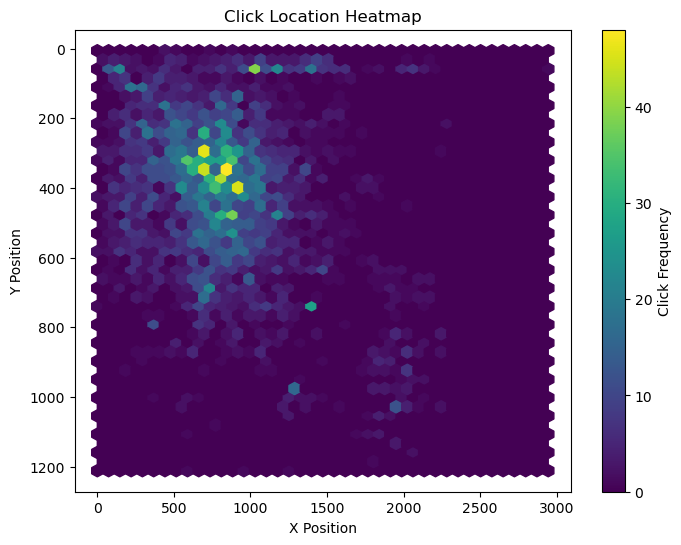

In [12]:
#Click Location Heatmap 
clicks_df = df[df["type"] == "click"]

plt.figure(figsize=(8, 6))
plt.hexbin(clicks_df["x"], clicks_df["y"], gridsize=40, cmap="viridis")
plt.xlabel("X Position")
plt.ylabel("Y Position")
plt.title("Click Location Heatmap")
plt.colorbar(label="Click Frequency")
plt.gca().invert_yaxis()  # flip Y-axis if origin is top-left
plt.show()

In [13]:
#view full dataset 
df.head(10)

,session_id,timestamp,type,x,y,screen_width,screen_height,time_delta,x_prev,y_prev,dx,dy,distance,speed,datetime
0,session_1740747600010_n0ja7c6z,1740747600100,enter,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2025-02-28 13:00:00.100
1,session_1740749591318_8meh9m5x,1740749617826,click,246.0,575.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2025-02-28 13:33:37.826
2,session_1740749591318_8meh9m5x,1740749657779,click,662.0,550.0,NaN,NaN,39953.0,NaN,NaN,NaN,NaN,416.750525,NaN,2025-02-28 13:34:17.779
3,session_1740749591318_8meh9m5x,1740749665512,click,498.0,279.0,NaN,NaN,7733.0,NaN,NaN,NaN,NaN,316.760162,NaN,2025-02-28 13:34:25.512
4,session_1740749591318_8meh9m5x,1740749668991,click,511.0,324.0,NaN,NaN,3479.0,NaN,NaN,NaN,NaN,46.840154,NaN,2025-02-28 13:34:28.991
5,session_1740749591318_8meh9m5x,1740749669513,click,511.0,324.0,NaN,NaN,522.0,NaN,NaN,NaN,NaN,0.000000,NaN,2025-02-28 13:34:29.513
6,session_1740749591318_8meh9m5x,1740749670193,click,320.0,84.0,NaN,NaN,680.0,NaN,NaN,NaN,NaN,306.726262,NaN,2025-02-28 13:34:30.193
7,session_1740749591318_8meh9m5x,1740749670395,click,320.0,84.0,NaN,NaN,202.0,NaN,NaN,NaN,NaN,0.000000,NaN,2025-02-28 13:34:30.395
8,session_1740749591318_8meh9m5x,1740749672856,click,320.0,224.0,NaN,NaN,2461.0,NaN,NaN,NaN,NaN,140.000000,NaN,2025-02-28 13:34:32.856
9,session_1740749591318_8meh9m5x,1740749697518,leave,NaN,NaN,NaN,NaN,24662.0,NaN,NaN,NaN,NaN,NaN,NaN,2025-02-28 13:34:57.518


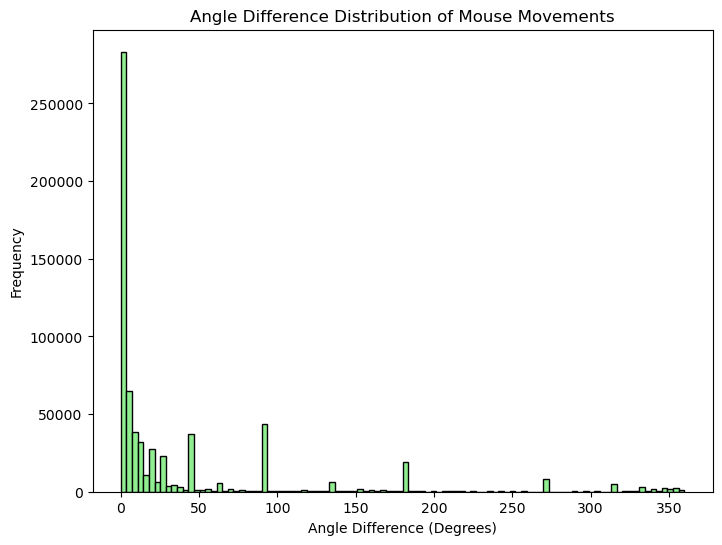

In [17]:
# Angle between consecutive points
df['angle'] = np.arctan2(df['dy'], df['dx']) * 180 / np.pi  # Convert to degrees

# Angle difference between consecutive movements
df['angle_diff'] = df['angle'].diff().abs()

plt.figure(figsize=(8, 6))
plt.hist(df['angle_diff'].dropna(), bins=100, color='lightgreen', edgecolor='black')
plt.xlabel("Angle Difference (Degrees)")
plt.ylabel("Frequency")
plt.title("Angle Difference Distribution of Mouse Movements")
plt.show()


In [18]:
# Defining hover as staying within a small radius for a duration
HOVER_RADIUS = 10  # pixels
HOVER_TIME_THRESHOLD = 500  # ms

df["within_hover_radius"] = df["distance"] < HOVER_RADIUS
df["hover_candidate"] = (df["within_hover_radius"]) & (df["time_delta"] > HOVER_TIME_THRESHOLD)

hover_counts = df.groupby("session_id")["hover_candidate"].sum().reset_index()
hover_counts.rename(columns={"hover_candidate": "num_hovers"}, inplace=True)

In [19]:
# Defining jitter as small erratic changes
df["is_jitter"] = df["distance"] < 3
jitter_counts = df.groupby("session_id")["is_jitter"].sum().reset_index()
jitter_counts.rename(columns={"is_jitter": "jitter_count"}, inplace=True)

In [20]:
#check shape 
df.shape

(685529, 21)

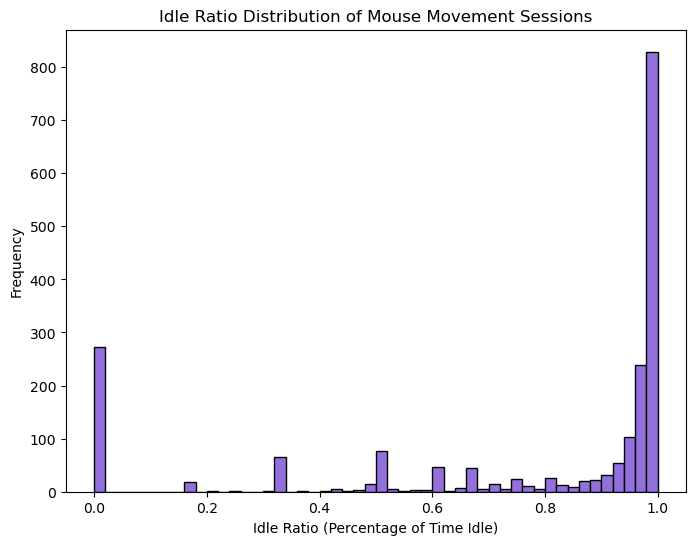

In [22]:
# Identify idle periods where time delta exceeds a threshold (e.g., 500ms)
threshold = 0.5  # 500ms threshold for idle time
df['is_idle'] = df['time_delta'] > threshold

# Aggregate idle ratios per session
idle_ratio = df.groupby('session_id')['is_idle'].mean()

plt.figure(figsize=(8, 6))
plt.hist(idle_ratio, bins=50, color='mediumpurple', edgecolor='black')
plt.xlabel("Idle Ratio (Percentage of Time Idle)")
plt.ylabel("Frequency")
plt.title("Idle Ratio Distribution of Mouse Movement Sessions")
plt.show()


<Figure size 1000x800 with 0 Axes>

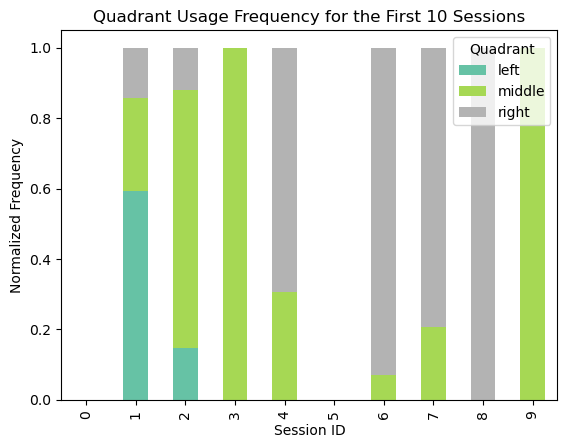

In [23]:
#Quadrant Usage Heatmap 
#Compute quadrant usage
df['quadrant'] = pd.cut(df['x'], bins=[0, 500, 1000, np.inf], labels=["left", "middle", "right"])
quadrant_freq = df.groupby(["session_id", "quadrant"]).size().unstack(fill_value=0)
quadrant_freq = quadrant_freq.div(quadrant_freq.sum(axis=1), axis=0).reset_index()

# Plot the quadrant usage for a few users
plt.figure(figsize=(10, 8))
quadrant_freq.iloc[:10, 1:].plot(kind="bar", stacked=True, colormap="Set2")
plt.xlabel("Session ID")
plt.ylabel("Normalized Frequency")
plt.title("Quadrant Usage Frequency for the First 10 Sessions")
plt.legend(title="Quadrant", loc="upper right")
plt.show()


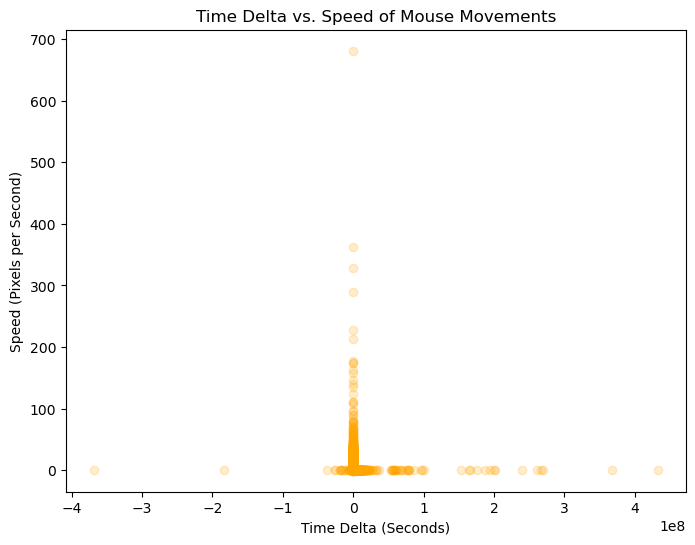

In [25]:
plt.figure(figsize=(8, 6))
plt.scatter(df['time_delta'], df['speed'], alpha=0.2, color='orange')
plt.xlabel("Time Delta (Seconds)")
plt.ylabel("Speed (Pixels per Second)")
plt.title("Time Delta vs. Speed of Mouse Movements")
plt.show()

In [65]:
#checking the dataset object 
print(cursor_data)

DatasetDict({
    train: Dataset({
        features: ['session_id', 'timestamp', 'type', 'x', 'y', 'screen_width', 'screen_height', 'time_delta', 'x_prev', 'y_prev', 'dx', 'dy', 'distance', 'speed', 'datetime'],
        num_rows: 685529
    })
})
